<a href="https://colab.research.google.com/github/DeemOne-personal/Python-lessons-deep/blob/main/homework_1_boosting_and_explanation_source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1
## Gradient boosting on temporal data and feature importances


Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). Download it and place in `data/` folder in the same directory as this notebook. There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

Today we will work with [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. It is one of the most popular frameworks these days that shows both great quality and performance.

There are another great frameworks (listed below). However, we will stick to `LightGBM` for this task.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.
* [Catboost](https://github.com/catboost/catboost) by Yandex. Novel framework by Yandex company tuned to deal well with categorical features.

Some simple preprocessing is done for you. 

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to. __Please, use [`shap`](https://github.com/slundberg/shap) and interpret the generated plots (with a brief summary).__

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian._

## Part 0. Preprocessing.
The preprocessing is done for you. Let's take a look at the data.

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#added
from google.colab import drive
drive.mount('/content/drive')
import numpy as np

Mounted at /content/drive


In [4]:
X_train = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/Edu4 - DS MFTI Adv/Files/train/X_train.txt')
y_train = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/Edu4 - DS MFTI Adv/Files/train/y_train.txt')

X_test = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/Edu4 - DS MFTI Adv/Files/test/X_test.txt')
y_test = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/Edu4 - DS MFTI Adv/Files/test/y_test.txt')

with open('/content/drive/MyDrive/Colab Notebooks/Edu4 - DS MFTI Adv/Files/activity_labels.txt', 'r') as file:
    activity_labels = file.readlines()

activity_labels = [x.replace('\n', '').split(' ') for x in activity_labels]
activity_labels = dict([(int(x[0]), x[1]) for x in activity_labels])

Lets look at the values we want to predict:

In [4]:
activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [5]:
print(X_train.shape)
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean)/data_std
X_test = (X_test - data_mean)/data_std

(7352, 561)


The dataset has some duplicating features. File `unique_columns.txt` stores the indices of the unique ones. 

In [6]:
unique_columns = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/Edu4 - DS MFTI Adv/Files/unique_columns.txt', delimiter=',').astype(int)
X_train_unique = X_train[:, unique_columns]
X_test_unique = X_test[:, unique_columns]

In [7]:
#measuring of how does slicing affects on the matrix
print('num of the unique columns to apply: '+str(len(unique_columns)))
print('initial matrix size:' + str(X_train.shape))
print('matrix size after filtering unique columns: '+ str(X_train_unique.shape))

num of the unique columns to apply: 540
initial matrix size:(7352, 561)
matrix size after filtering unique columns: (7352, 540)


Result is: number of columns (features) decreased 561 -> 540

In [ ]:
#just 4 test how slicing works on matrix
array = np.arange(75).reshape(5,5,3)
array[:,[0,1,2]]
print(array.shape)


In [ ]:
#https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
from sklearn.preprocessing import StandardScaler
print(array)
array = np.arange(20).reshape(5,4)
array_scaled = StandardScaler().fit_transform(array)
print('***********')
print(array_scaled)
pca =PCA(2)
array_PCA = pca.fit_transform(array_scaled)
print('***********')
print(array_PCA)

PCA could be useful in this case. E.g.

Added more information:

https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [11]:
pca = PCA(0.8)
X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)
print('train: '+str(X_train_pca.shape))
print('test: '+str(X_test_pca.shape))

train: (7352, 27)
test: (2947, 27)


Text(0, 0.5, 'Principal component 2')

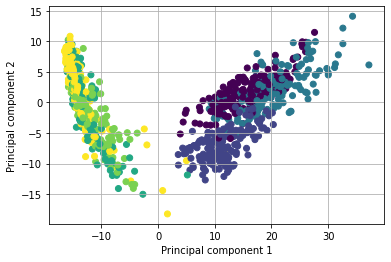

In [72]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

Text(0, 0.5, 'Principal component 5')

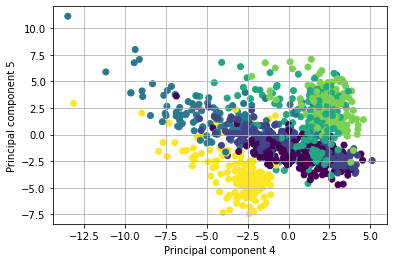

In [73]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 4')
plt.ylabel('Principal component 5')

## Part 1. Fit the model.

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to approximate them by yourself.

In this part just check some hyperparams by hand.

https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
### Example: https://rpubs.com/burakh/har_xgb

In [126]:
#SKLEARN API
#https://xgboost.readthedocs.io/en/latest/

import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer


def run_model(X, y, params):
  
  print("X shape is:" + str(X.shape))
  print("y shape is:" + str(y.shape))

  model = XGBClassifier(**params)
  #print(model.get_params)
  print(model.get_xgb_params())

  # fit is SKlearn-compatible without encode to xgb.DMatrix
  model.fit(X, y)

  # predict the target on the train dataset
  y_preds = model.predict(X)
  print('\nTargets are: ', y_preds) 

  # classification report
  print('classification report')
  score = model.score(X, y)
  print("Accuracy: {}".format(score))
  print("Classification report:")
  print(classification_report(y, y_preds))


In [125]:
#TRAIN NO PARAMS
run_model(X_train_pca, y_train, {})

X shape is:(7352, 27)
y shape is:(7352,)
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 1, 'verbosity': 1}

Targets are:  [5. 5. 5. ... 2. 2. 2.]
classification report
Accuracy: 0.9464091403699674
Classification report:
              precision    recall  f1-score   support

         1.0       0.98      0.98      0.98      1226
         2.0       0.98      0.98      0.98      1073
         3.0       0.98      0.98      0.98       986
         4.0       0.91      0.82      0.87      1286
         5.0       0.85      0.93      0.89      1374
         6.0       1.00      1.00      1.00      1407

    accuracy                           0.95      7352
   macro avg       0.95 

In [132]:
#TRAIN WITH PARAMS
params = {'objective':'binary:logistic', 'n_estimators':100, 'learning_rate':1, 'max_depth':8, 'subsample':0.5}
run_model(X_train_pca, y_train, params)

X shape is:(7352, 27)
y shape is:(7352,)
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.5, 'verbosity': 1}

Targets are:  [5. 5. 5. ... 2. 2. 2.]
classification report
Accuracy: 1.0
Classification report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      1226
         2.0       1.00      1.00      1.00      1073
         3.0       1.00      1.00      1.00       986
         4.0       1.00      1.00      1.00      1286
         5.0       1.00      1.00      1.00      1374
         6.0       1.00      1.00      1.00      1407

    accuracy                           1.00      7352
   macro avg       1.00      1.00      

In [121]:
#TEST NO PARAMS
run_model(X_test_pca, y_test, {})

X shape is:(2947, 27)
y shape is:(2947,)
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 1, 'verbosity': 1}

Targets are:  [5. 5. 5. ... 2. 2. 2.]
classification report
Accuracy: 0.9837122497455039
Classification report:
              precision    recall  f1-score   support

         1.0       0.99      1.00      0.99       496
         2.0       1.00      1.00      1.00       471
         3.0       1.00      0.99      0.99       420
         4.0       0.95      0.97      0.96       491
         5.0       0.97      0.95      0.96       532
         6.0       1.00      1.00      1.00       537

    accuracy                           0.98      2947
   macro avg       0.98 

In [124]:
#TEST WITH PARAMS
params = {'objective':'binary:logistic', 'n_estimators':100, 'learning_rate':1}
run_model(X_test_pca, y_test, params)

X shape is:(2947, 27)
y shape is:(2947,)
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 1, 'verbosity': 1}

Targets are:  [5. 5. 5. ... 2. 2. 2.]
classification report
Accuracy: 1.0
Classification report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       496
         2.0       1.00      1.00      1.00       471
         3.0       1.00      1.00      1.00       420
         4.0       1.00      1.00      1.00       491
         5.0       1.00      1.00      1.00       532
         6.0       1.00      1.00      1.00       537

    accuracy                           1.00      2947
   macro avg       1.00      1.00      1.

#@Экспериментальный код

In [75]:
#NATIVE API

import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer


def run_model(X, y):
  
  print("X shape is:" + str(X.shape))
  print("y shape is:" + str(y.shape))

  X=xgb.DMatrix(X_train_pca)
  
  # specify parameters via map
  param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
  num_round = 2
  bst = xgb.train(param, X, num_round)
  # make prediction
  preds = bst.predict(dtest)

  # classification report
  #score = model.score(X, y)
  #print("Accuracy: {}".format(score))
 # print("Classification report:")
  #print(classification_report(y, y_preds))

run_model(X_train_pca, y_train)

X shape is:(7352, 27)
y shape is:(7352,)


XGBoostError: ignored

In [66]:
#DEFAULT REALISATION

import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer


def run_model(X, y, params):
  
  print("X shape is:" + str(X.shape))
  print("y shape is:" + str(y.shape))

  #https://xgboost.readthedocs.io/en/latest/
  #
  # param_dist = {'objective':'binary:logistic', 'n_estimators':2}

  model = XGBClassifier(**params)
  for i in model.get_xgb_params():
    print(type(i))

  # fit the model with the training data
  # fit is SKlearn-compatible wrapper is better
  # with no need to encode to xgb.DMatrix
  model.fit(X, y)

  # predict the target on the train dataset
  y_preds = model.predict(X)
  print('\nTargets are: ', y_preds) 

  # classification report
  score = model.score(X, y)
  print("Accuracy: {}".format(score))
  print("Classification report:")
  print(classification_report(y, y_preds))

https://stackoverflow.com/questions/47152610/what-is-the-difference-between-xgb-train-and-xgb-xgbregressor-or-xgb-xgbclassif


In [59]:
#params usage
#params = {'eta':1, 'objective':'binary:logistic' }
#params={'n_estimators':1000, 'learning_rate':0.05}
#'n_estimators=1000, learning_rate=0.05'
params = {'objective':'binary:logistic', 'n_estimators':10, 'learning_rate':0.05}
run_model(X_train_pca, y_train, params)

X shape is:(7352, 27)
y shape is:(7352,)

Targets are:  [4. 5. 5. ... 2. 2. 2.]
Accuracy: 0.8254896626768227
Classification report:
              precision    recall  f1-score   support

         1.0       0.80      0.88      0.83      1226
         2.0       0.82      0.81      0.82      1073
         3.0       0.86      0.78      0.82       986
         4.0       0.81      0.60      0.69      1286
         5.0       0.74      0.90      0.81      1374
         6.0       0.95      0.96      0.95      1407

    accuracy                           0.83      7352
   macro avg       0.83      0.82      0.82      7352
weighted avg       0.83      0.83      0.82      7352



Train score:

In [55]:
#default params
run_model(X_train_pca, y_train,params)

X shape is:(7352, 27)
y shape is:(7352,)

Targets are:  [5. 5. 5. ... 2. 2. 2.]
Accuracy: 0.9983677910772579
Classification report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      1226
         2.0       1.00      1.00      1.00      1073
         3.0       1.00      1.00      1.00       986
         4.0       1.00      0.99      1.00      1286
         5.0       0.99      1.00      1.00      1374
         6.0       1.00      1.00      1.00      1407

    accuracy                           1.00      7352
   macro avg       1.00      1.00      1.00      7352
weighted avg       1.00      1.00      1.00      7352



X shape is:(7352, 27)
y shape is:(7352,)


XGBoostError: ignored

Test score:

In [128]:
run_model(X_test_pca, y_test)

X shape is:(2947, 27)
y shape is:(2947,)

Targets are:  [5. 5. 5. ... 2. 2. 2.]
Accuracy: 0.9837122497455039
Classification report:
              precision    recall  f1-score   support

         1.0       0.99      1.00      0.99       496
         2.0       1.00      1.00      1.00       471
         3.0       1.00      0.99      0.99       420
         4.0       0.95      0.97      0.96       491
         5.0       0.97      0.95      0.96       532
         6.0       1.00      1.00      1.00       537

    accuracy                           0.98      2947
   macro avg       0.98      0.98      0.98      2947
weighted avg       0.98      0.98      0.98      2947



Good result on test data with default parameters

In [131]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_boston

# Grid Search Parameters
grid_search_params = {
    'colsample_bytree': [0.3, 0.7],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'n_estimators': [100],
    'subsample': [0.2, 0.5, 0.8],
    'max_depth': [2, 3, 5]
}

xg_grid_reg = xgb.XGBRegressor(objective= "reg:squarederror")

grid = GridSearchCV(estimator=xg_grid_reg, param_grid=grid_search_params, scoring='neg_mean_squared_error',
                    cv=4, verbose=1, iid=True)

grid.fit(X_test_pca, y_test)
print("GridSearchCV")
print("Best parameters found: ", grid.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid.best_score_)))

Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:  1.2min finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.2}
Lowest RMSE found:  0.5430790666068437


Please, write down your thoughts on the experiment results.

## Part 2. Use hyper parameter tuning system

Use [optuna](https://optuna.org/), [hyperopt](http://hyperopt.github.io/hyperopt/) or any other zero order optimizer to find optimal hyper param set.

In [ ]:
# YOUR CODE HERE

### Part 3. Interpret the model predictions
Despite you are free to use any approaches to interpret the model predictions, please use [`shap`](https://github.com/slundberg/shap) to build some plots (e.g. the ones we've seen on week02) and try to interpret them.

In [ ]:
import shap

# YOUR CODE HERE

_Your thoughts about the plots and model behaviour._

https://stackoverflow.com/questions/47152610/what-is-the-difference-between-xgb-train-and-xgb-xgbregressor-or-xgb-xgbclassif